# Importing Libraries


In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing


In [ ]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# Dataset Loading


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"


In [ ]:
!kaggle datasets download - d deepcontractor/smoke-detection-dataset


  0% 0.00/1.64M [00:00<?, ?B/s]
100% 1.64M/1.64M [00:00<00:00, 128MB/s]


In [ ]:
!unzip / content/smoke-detection-dataset.zip


Archive:  /content/smoke-detection-dataset.zip
  inflating: smoke_detection_iot.csv  


In [ ]:
df = pd.read_csv("/content/smoke_detection_iot.csv")
df = df.drop("Unnamed: 0", axis=1)
df


,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62630 non-null  int64  
 1   Temperature[C]  62630 non-null  float64
 2   Humidity[%]     62630 non-null  float64
 3   TVOC[ppb]       62630 non-null  int64  
 4   eCO2[ppm]       62630 non-null  int64  
 5   Raw H2          62630 non-null  int64  
 6   Raw Ethanol     62630 non-null  int64  
 7   Pressure[hPa]   62630 non-null  float64
 8   PM1.0           62630 non-null  float64
 9   PM2.5           62630 non-null  float64
 10  NC0.5           62630 non-null  float64
 11  NC1.0           62630 non-null  float64
 12  NC2.5           62630 non-null  float64
 13  CNT             62630 non-null  int64  
 14  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(7)
memory usage: 7.2 MB


In [ ]:
df.describe()


,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,6.263000e+04,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,1.654792e+09,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,10511.386157,0.714626
std,1.100025e+05,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,7597.870997,0.451596
min,1.654712e+09,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.654743e+09,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.250000,0.000000
50%,1.654762e+09,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,9336.000000,1.000000
75%,1.654778e+09,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.750000,1.000000
max,1.655130e+09,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


Features Heat Map


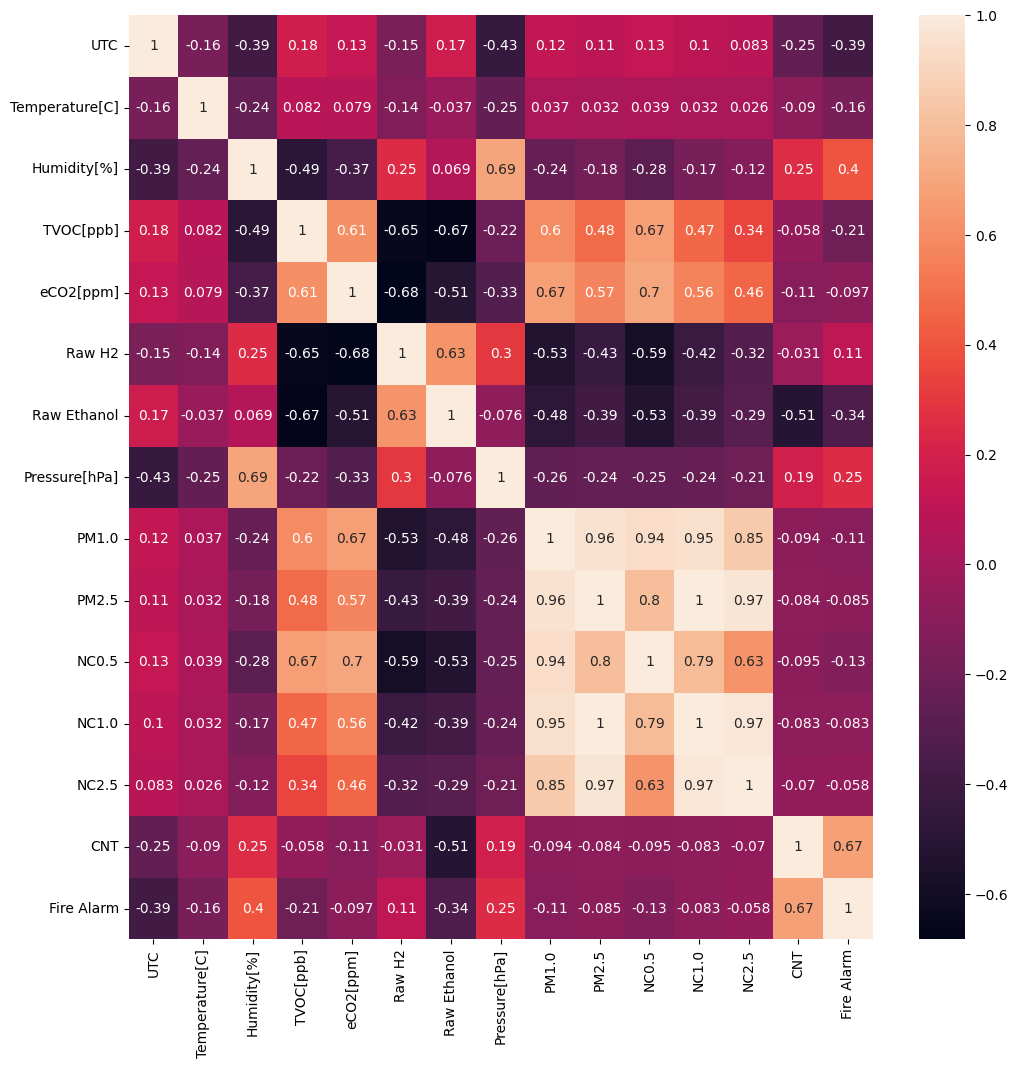

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True)
plt.show()


Target Value Distribution


In [ ]:
df['Fire Alarm'].value_counts()


1    44757
0    17873
Name: Fire Alarm, dtype: int64

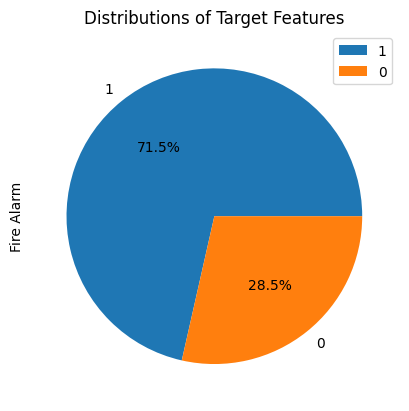

In [ ]:
df['Fire Alarm'].value_counts().plot(kind="pie", autopct="%.1f%%")
plt.title("Distributions of Target Features")
plt.legend()
plt.show()


In [ ]:
df.head()


,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [ ]:
# No Missing Values
# No categorical Values
df.columns


Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]',
       'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5',
       'NC1.0', 'NC2.5', 'CNT', 'Fire Alarm'],
      dtype='object')

<Axes: xlabel='Humidity[%]', ylabel='Count'>

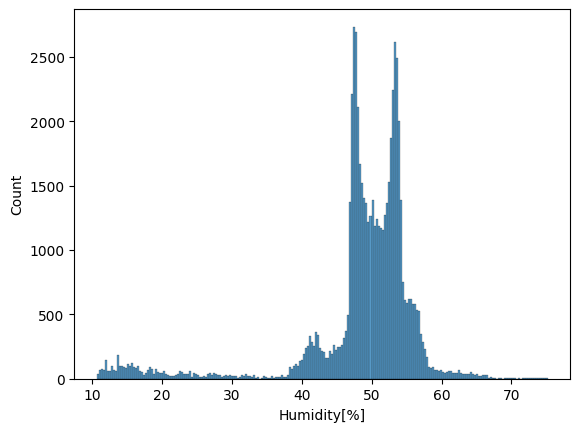

In [ ]:
sns.histplot(data=df, x=df['Humidity[%]'])


<Axes: xlabel='Raw H2', ylabel='Count'>

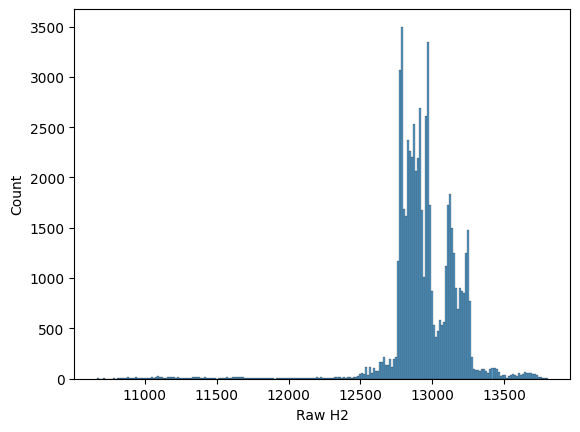

In [ ]:
sns.histplot(data=df, x=df['Raw H2'])


<Axes: xlabel='Raw Ethanol', ylabel='Count'>

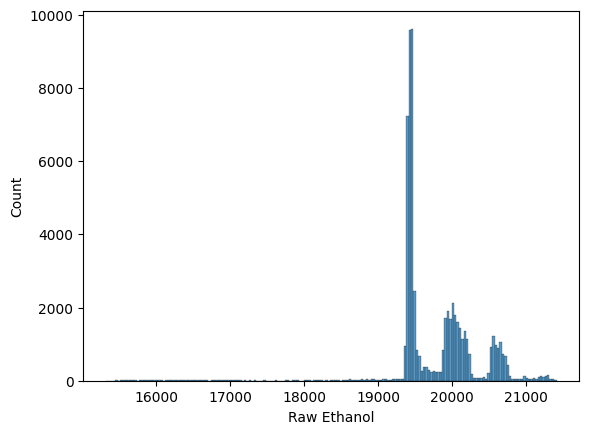

In [ ]:
sns.histplot(data=df, x=df['Raw Ethanol'])


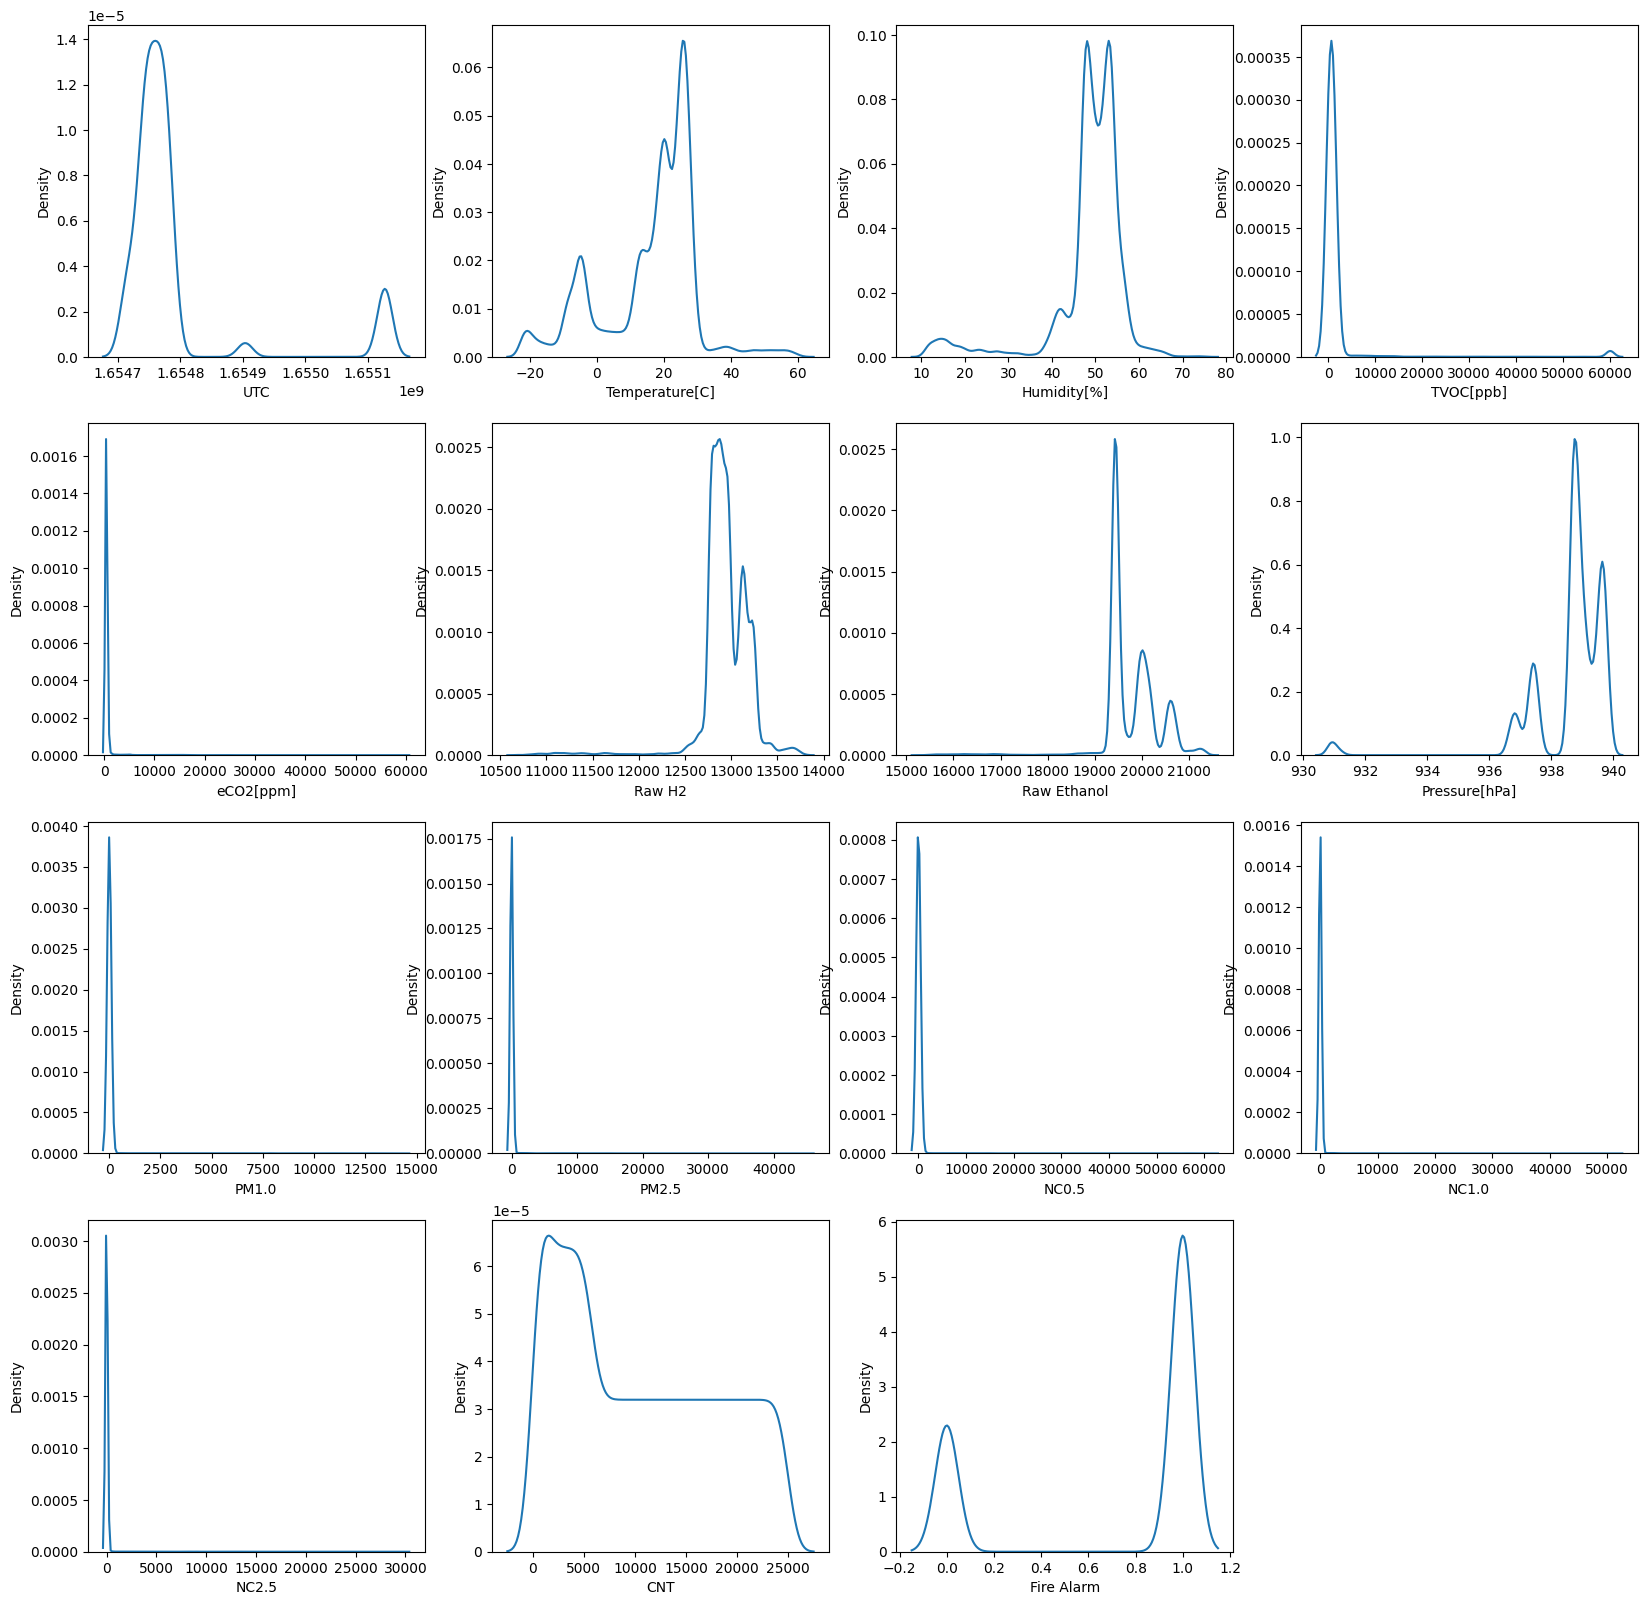

In [ ]:
plt.figure(figsize=(20, 25))
i = 1
for col in df.columns:
    plt.subplot(5, 4, i)
    sns.kdeplot(df[col])
    i += 1


Changing Skewness


In [ ]:
df.skew()


UTC                2.546510
Temperature[C]    -0.619907
Humidity[%]       -2.460755
TVOC[ppb]          6.776903
eCO2[ppm]         12.459812
Raw H2            -2.910064
Raw Ethanol       -1.684619
Pressure[hPa]     -3.603997
PM1.0             10.752666
PM2.5             14.146225
NC0.5             10.041323
NC1.0             14.447496
NC2.5             17.736729
CNT                0.324240
Fire Alarm        -0.950550
dtype: float64

Outlier Detection


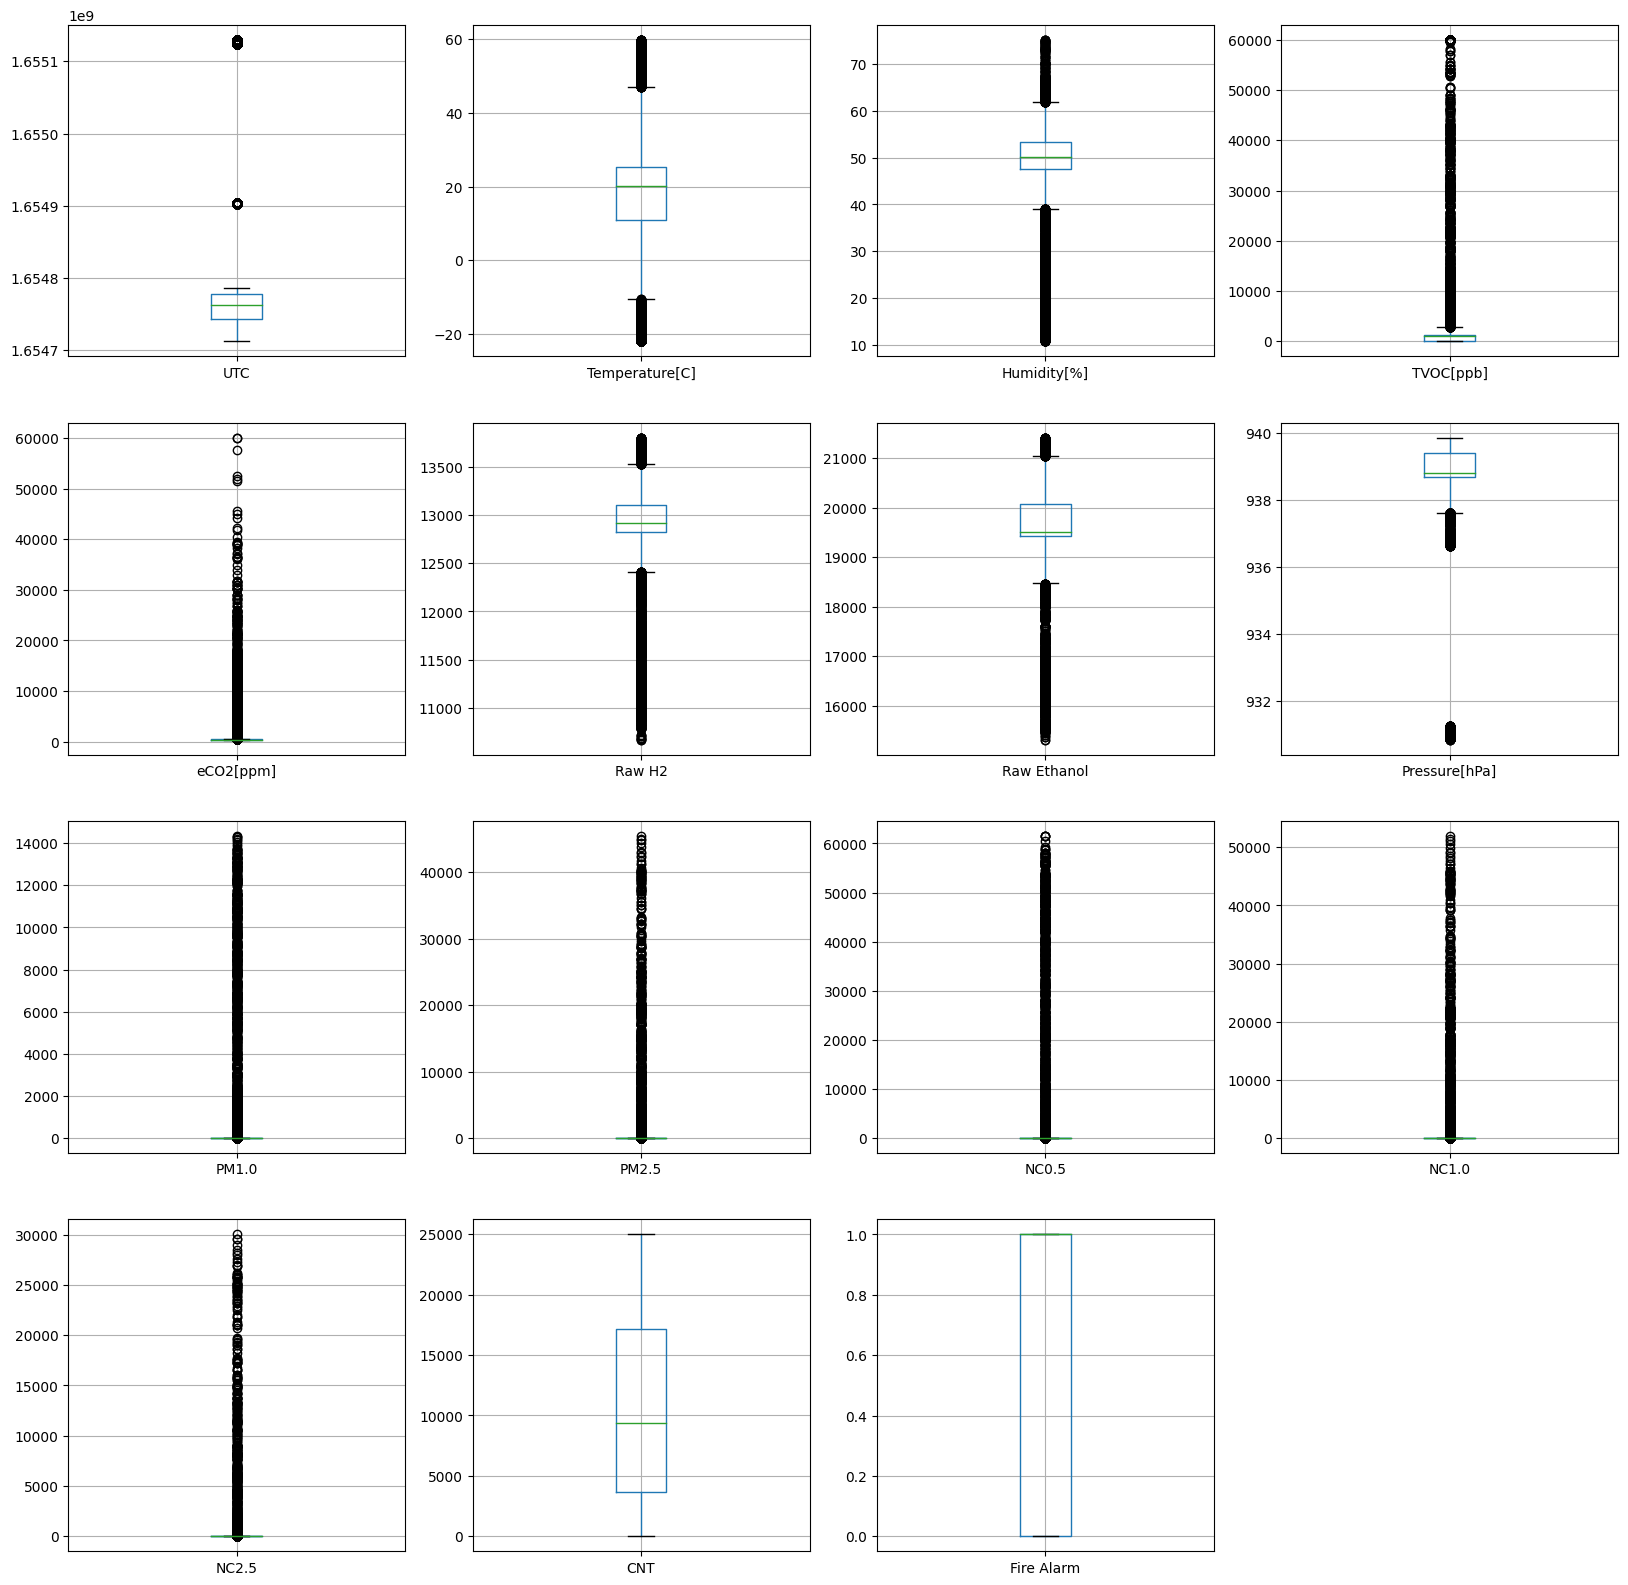

In [ ]:
plt.figure(figsize=(20, 25))
i = 1
for col in df.columns:
    plt.subplot(5, 4, i)
    df[[col]].boxplot()
    i += 1


In [ ]:
df.columns = ['UTC', 'Temperature_C', 'Humidity_%', 'TVOC_ppb', 'eCO2_ppm',
              'Raw H2', 'Raw Ethanol', 'Pressure_hPa', 'PM1.0', 'PM2.5', 'NC0.5',
              'NC1.0', 'NC2.5', 'CNT', 'Fire Alarm']


## Split the Data


In [ ]:
x = df.drop("Fire Alarm", axis=1)
y = df['Fire Alarm']


In [ ]:
df.columns


Index(['UTC', 'Temperature_C', 'Humidity_%', 'TVOC_ppb', 'eCO2_ppm', 'Raw H2',
       'Raw Ethanol', 'Pressure_hPa', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0',
       'NC2.5', 'CNT', 'Fire Alarm'],
      dtype='object')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.10, shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(56367, 14)
(6263, 14)
(56367,)
(6263,)


In [ ]:
x_train.head()


,UTC,Temperature_C,Humidity_%,TVOC_ppb,eCO2_ppm,Raw H2,Raw Ethanol,Pressure_hPa,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
13689,1654747020,19.129,48.58,1130,511,12848,19455,938.890,2.05,2.13,14.09,2.197,0.050,13689
13059,1654746390,20.806,51.43,1099,547,12834,19456,938.912,2.35,2.44,16.17,2.522,0.057,13059
7950,1654741281,-4.151,49.92,299,400,13116,19961,939.408,0.30,0.31,2.09,0.325,0.007,7950
44273,1654780622,26.950,47.86,1182,400,12921,19432,938.688,1.39,1.44,9.56,1.490,0.034,19279
37024,1654773373,27.010,46.97,1051,578,12827,19473,939.011,1.98,2.05,13.61,2.122,0.048,12030


In [ ]:
y_train


13689    1
13059    1
7950     1
44273    1
37024    1
        ..
44458    1
9004     1
39145    1
50843    1
11571    1
Name: Fire Alarm, Length: 56367, dtype: int64

In [ ]:
x_train


,UTC,Temperature_C,Humidity_%,TVOC_ppb,eCO2_ppm,Raw H2,Raw Ethanol,Pressure_hPa,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
13689,1654747020,19.129,48.58,1130,511,12848,19455,938.890,2.05,2.13,14.09,2.197,0.050,13689
13059,1654746390,20.806,51.43,1099,547,12834,19456,938.912,2.35,2.44,16.17,2.522,0.057,13059
7950,1654741281,-4.151,49.92,299,400,13116,19961,939.408,0.30,0.31,2.09,0.325,0.007,7950
44273,1654780622,26.950,47.86,1182,400,12921,19432,938.688,1.39,1.44,9.56,1.490,0.034,19279
37024,1654773373,27.010,46.97,1051,578,12827,19473,939.011,1.98,2.05,13.61,2.122,0.048,12030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44458,1654780807,27.040,47.65,1218,400,12923,19422,938.678,1.81,1.88,12.44,1.939,0.044,19464
9004,1654742335,-5.229,51.52,361,400,13061,19906,939.264,0.47,0.48,3.21,0.500,0.011,9004
39145,1654775494,24.580,52.98,1109,500,12849,19453,938.922,1.98,2.05,13.59,2.120,0.048,14151
50843,1654903860,36.530,15.16,162,2224,12656,20425,930.866,0.97,1.01,6.68,1.042,0.024,855


## Scale the Data


In [ ]:
scaler = MinMaxScaler()
scaler.fit(x_train)


MinMaxScaler()

In [ ]:
x_train_scale = pd.DataFrame(
    scaler.transform(x_train), columns=x_train.columns)
x_test_scale = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


In [ ]:
x_train_scale.head()


,UTC,Temperature_C,Humidity_%,TVOC_ppb,eCO2_ppm,Raw H2,Raw Ethanol,Pressure_hPa,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
0,0.083360,0.502062,0.587031,0.018833,0.001862,0.695375,0.679140,0.892219,0.000143,0.000047,0.000229,0.000042,1.665199e-06,0.547713
1,0.081852,0.522529,0.631244,0.018317,0.002466,0.690909,0.679304,0.894661,0.000164,0.000054,0.000263,0.000049,1.898327e-06,0.522506
2,0.069626,0.217952,0.607819,0.004983,0.000000,0.780861,0.762186,0.949717,0.000021,0.000007,0.000034,0.000006,2.331279e-07,0.318089
3,0.163773,0.597510,0.575861,0.019700,0.000000,0.718660,0.675365,0.869797,0.000097,0.000032,0.000155,0.000029,1.132335e-06,0.771376
4,0.146426,0.598243,0.562054,0.017517,0.002987,0.688676,0.682094,0.905650,0.000138,0.000045,0.000221,0.000041,1.598591e-06,0.481335


In [ ]:
x_test_scale.head()


,UTC,Temperature_C,Humidity_%,TVOC_ppb,eCO2_ppm,Raw H2,Raw Ethanol,Pressure_hPa,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT
0,0.103440,0.096766,0.673751,0.023117,0.000117,0.730144,0.666831,0.872239,0.000123,0.000040,0.000199,0.000037,0.000001,0.883447
1,0.992395,0.367818,0.488055,0.002517,0.000436,0.673365,0.862137,0.719170,0.000125,0.000041,0.000201,0.000037,0.000001,0.102629
2,0.157951,0.569319,0.656066,0.019283,0.000218,0.709091,0.677171,0.876235,0.000116,0.000038,0.000186,0.000034,0.000001,0.674029
3,0.103433,0.097254,0.671734,0.023467,0.000218,0.732057,0.667980,0.872794,0.000119,0.000039,0.000191,0.000035,0.000001,0.883327
4,0.004087,0.612643,0.511480,0.001800,0.000000,0.676555,0.870671,0.727495,0.000133,0.000043,0.000213,0.000039,0.000002,0.068339


In [ ]:
import warnings
warnings.filterwarnings("ignore")


# Model Creation


Create Base Model


In [ ]:
lg_model = LogisticRegression()
lg_model.fit(x_train_scale, y_train)


LogisticRegression()

In [ ]:
y_pred = lg_model.predict(x_test_scale)
y_pred


array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print()
print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1773   55]
 [ 146 4289]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95      1828
           1       0.99      0.97      0.98      4435

    accuracy                           0.97      6263
   macro avg       0.96      0.97      0.96      6263
weighted avg       0.97      0.97      0.97      6263



ROC Curve


In [ ]:
y_prob = lg_model.predict_proba(x_test_scale)
y_prob


array([[5.47051293e-12, 1.00000000e+00],
       [9.85927944e-01, 1.40720559e-02],
       [8.28760673e-08, 9.99999917e-01],
       ...,
       [9.55195099e-01, 4.48049014e-02],
       [9.66218367e-01, 3.37816326e-02],
       [9.83194735e-01, 1.68052650e-02]])

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_prob[:, 1])
print("ROC-AUC:", auc(fpr, tpr))


ROC-AUC: 0.996064106138016


PR Curve


In [ ]:
y_prob = lg_model.predict_proba(x_test_scale)
y_prob


array([[5.47051293e-12, 1.00000000e+00],
       [9.85927944e-01, 1.40720559e-02],
       [8.28760673e-08, 9.99999917e-01],
       ...,
       [9.55195099e-01, 4.48049014e-02],
       [9.66218367e-01, 3.37816326e-02],
       [9.83194735e-01, 1.68052650e-02]])

In [ ]:
p, r, threshold = precision_recall_curve(y_test, y_prob[:, 1])
print("PR-AUC:", auc(r, p))


PR-AUC: 0.9983462382593659


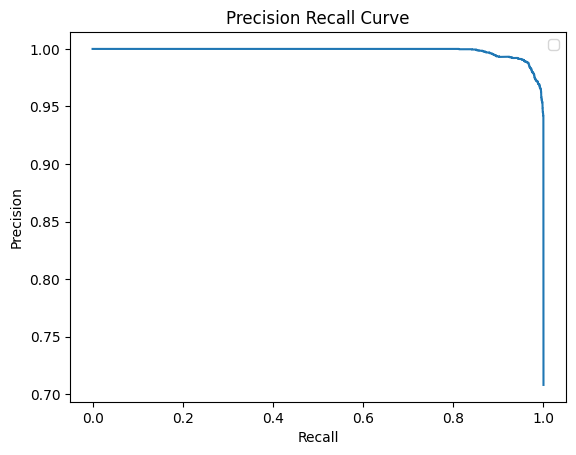

In [ ]:
plt.plot(r, p)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision Recall Curve")
plt.legend()
plt.show()


## XG Boost Model


In [ ]:
!pip install xgboost


In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_model.predict(x_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print()
print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1828    0]
 [   0 4435]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1828
           1       1.00      1.00      1.00      4435

    accuracy                           1.00      6263
   macro avg       1.00      1.00      1.00      6263
weighted avg       1.00      1.00      1.00      6263



## LGBMClassifier


In [ ]:
lgbm_model = LGBMClassifier()
lgbm_model.fit(x_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 40322, number of negative: 16045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 56367, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.715348 -> initscore=0.921500
[LightGBM] [Info] Start training from score 0.921500


LGBMClassifier()

In [ ]:
y_pred = lgbm_model.predict(x_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print()
print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[1828    0]
 [   0 4435]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1828
           1       1.00      1.00      1.00      4435

    accuracy                           1.00      6263
   macro avg       1.00      1.00      1.00      6263
weighted avg       1.00      1.00      1.00      6263

